pinn adds the loss of the diffrential equation that governs the process
e.g. du/dx + ku =0 then loss is sigma((d/dx + k)upred)^2

In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

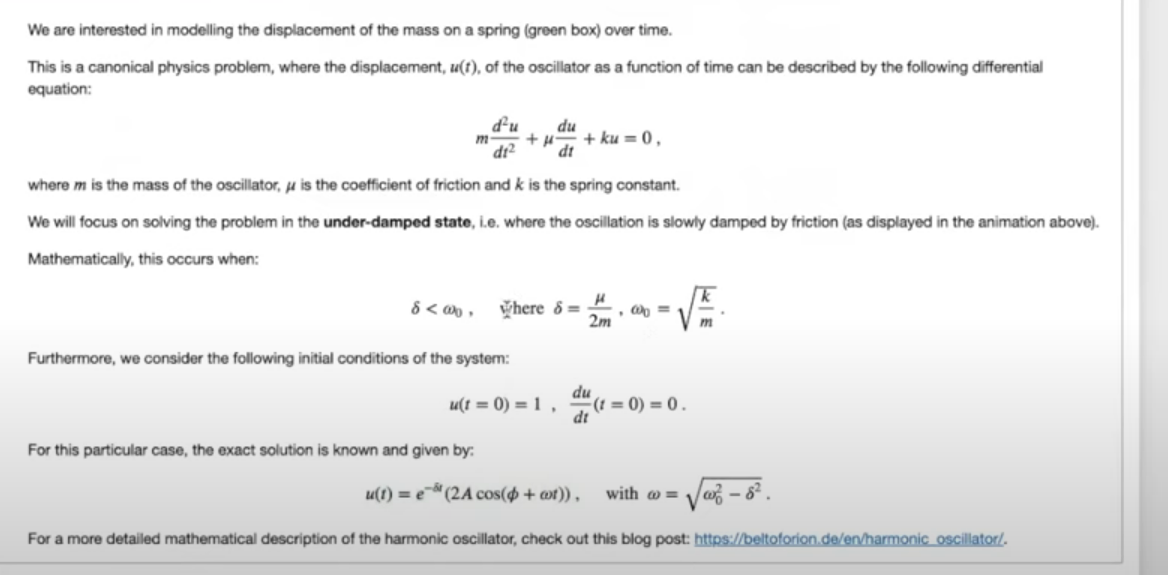

In [ ]:

def exact_solution (d, w0, t):
  "Defines the analytical solution to the under-damped harmonic oscillator problem above."
  assert d < w0
  w = np.sqrt(w0**2-d**2)
  phi = np.arctan(-d/w)
  A = 1/(2*np.cos (phi))
  cos= torch.cos(phi+w*t)
  exp = torch.exp(-d*t)
  u= exp*2*A*cos
  return u
class FCN (nn.Module):
  "Defines a standard fully-connected network in PyTorch"
  def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
    super().__init__()
    activation = nn.Tanh
    self.fcs = nn.Sequential(*[
        nn.Linear (N_INPUT, N_HIDDEN),
        activation()])
    self.fch =nn.Sequential(*[
        nn.Sequential (*[
            nn.Linear (N_HIDDEN, N_HIDDEN),
            activation()]) for _ in range(N_LAYERS-1)])
    self.fce = nn.Linear (N_HIDDEN, N_OUTPUT)
  def forward(self, x):
    x= self.fcs(x)
    x= self.fch(x)
    x= self.fce(x)
    return x

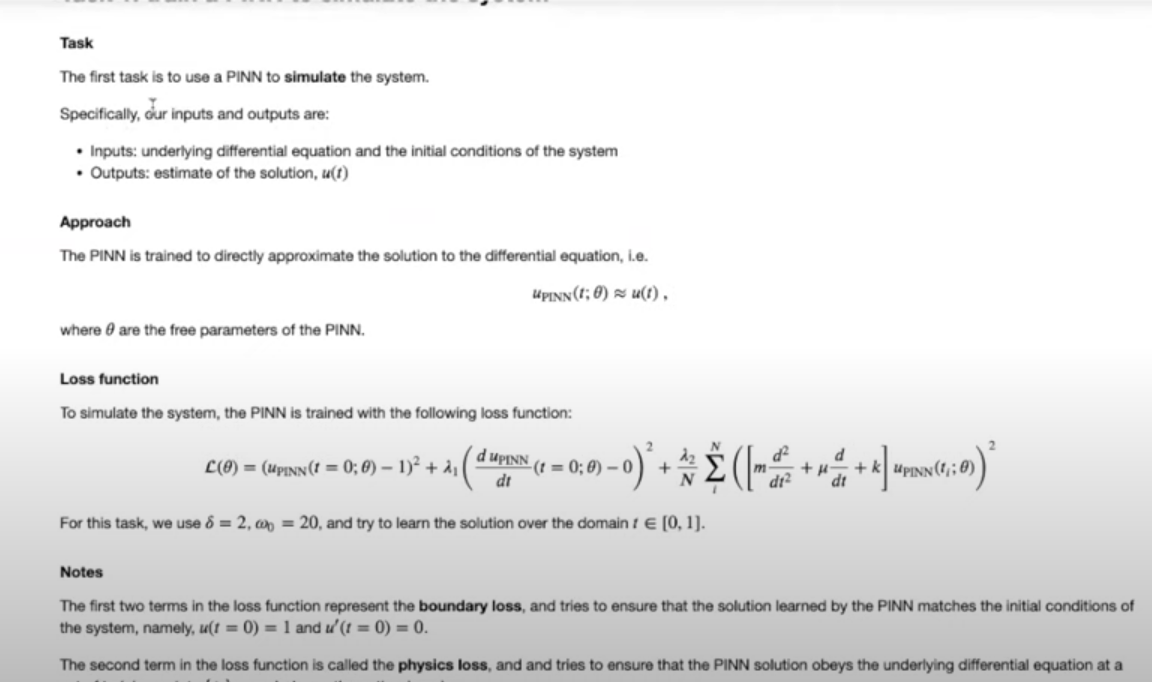

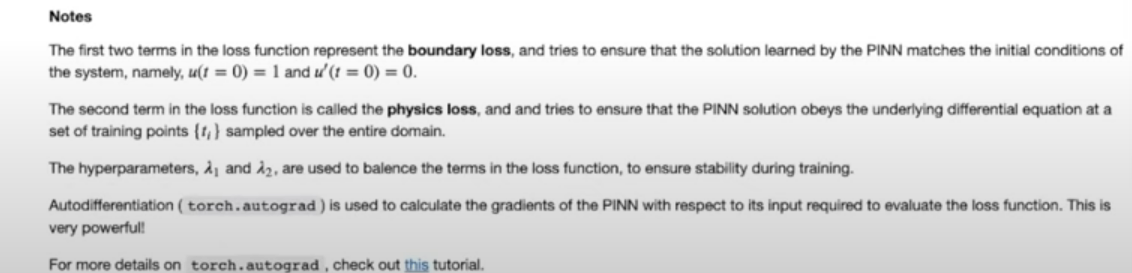

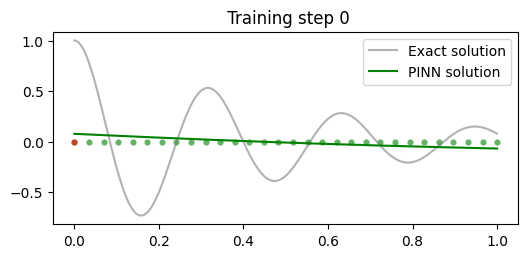

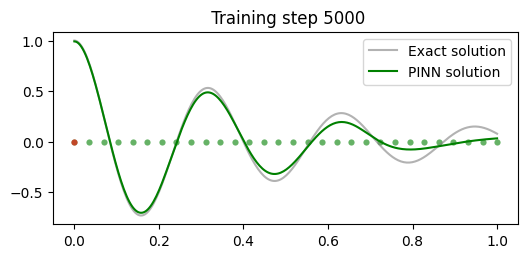

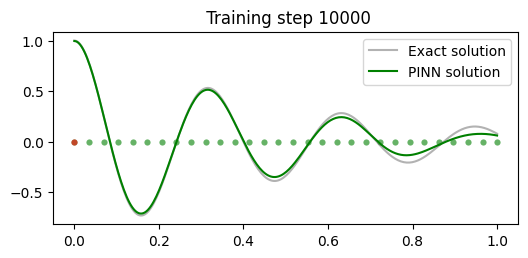

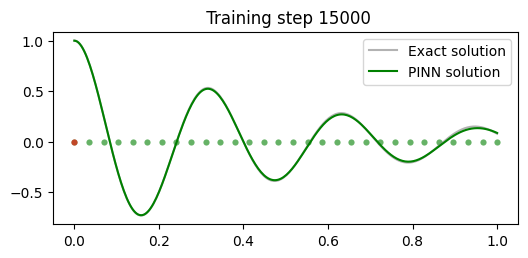

In [ ]:

torch.manual_seed (123)
# define a neural network to train

pinn = FCN (1,1,32,3)
#define boundary points, for the boundary loss
t_boundary= torch. tensor (0.). view (-1, 1).requires_grad_(True)
#The requires_grad controls whether gradients should be computed for a tensor during the backward pass.

# define training points over the entire domain, for the physics loss #TODO: write code here
t_physics = torch.linspace (0,1,30).view(-1, 1).requires_grad_(True)
# train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace (0,1,300). view (-1,1)
u_exact = exact_solution(d, w0, t_test)
optimiser = torch.optim.Adam (pinn. parameters(), lr=1e-3)
for i in range (15001):
  optimiser.zero_grad()
  #compute each term of the PINN loss function above
  # using the following hyperparameters:
  lambda1, lambda2 = 1e-1, 1e-4

  #compute boundary loss
  #the first two terms
  u = pinn(t_boundary)
  loss1 = (torch.squeeze(u)- 1)**2
  dudt = torch.autograd.grad(u,t_boundary,torch.ones_like(u), create_graph = True)[0]
  #need to pass the ones array, bcz torch use them in the back
  #the differentiation function - du/dt
  loss2 = (torch.squeeze(dudt)-0)**2

  #physics loss
  u = pinn(t_physics)
  dudt = torch.autograd.grad(u,t_physics,torch.ones_like(u), create_graph = True)[0]
  d2udt2 = torch.autograd.grad(dudt,t_physics,torch.ones_like(dudt), create_graph = True)[0]
  #second derivative
  loss3 = torch.mean((d2udt2+mu*dudt+k*u)**2)

  loss = loss1+ lambda1*loss2 + lambda2*loss3
  loss.backward()
  optimiser.step()



  # plot the result as training progresses
  if i%5000 == 0:
    #print (u. abs(). mean().item(), dudt.abs (). mean().item(), d2udt2.abs (). mean ().item())
    u = pinn (t_test). detach()
    plt.figure(figsize=(6,2.5))
    plt.scatter (t_physics.detach() [:,0],
                 torch.zeros_like(t_physics) [:,0], s=20, lw=0, c="green", alpha=0.6)
    plt.scatter (t_boundary.detach() [:,0],
                 torch.zeros_like(t_boundary) [:,0], s=20, lw=0, c="red", alpha=0.6)
    plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", c="grey", alpha=0.6)
    plt.plot(t_test[:,0], u[:,0], label="PINN solution", c="green")
    plt.title(f" Training step {i}")
    plt.legend()
    plt.show()

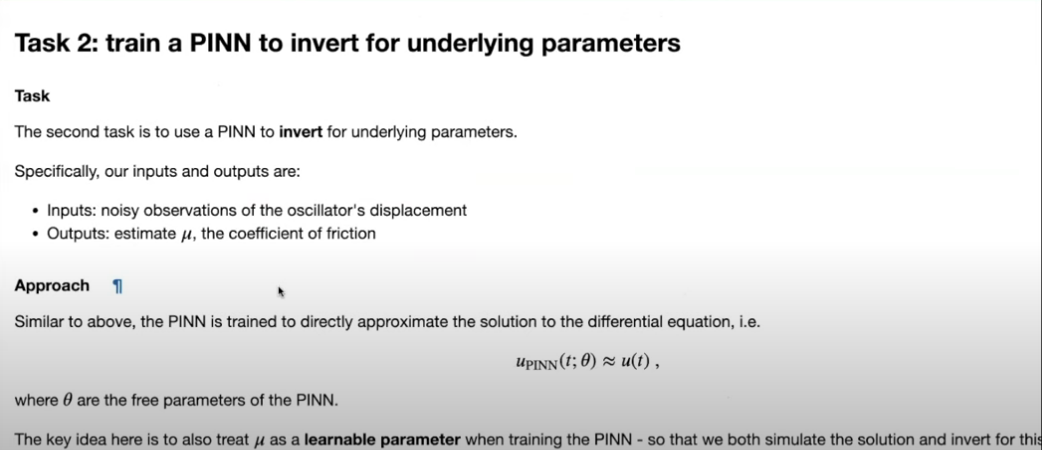

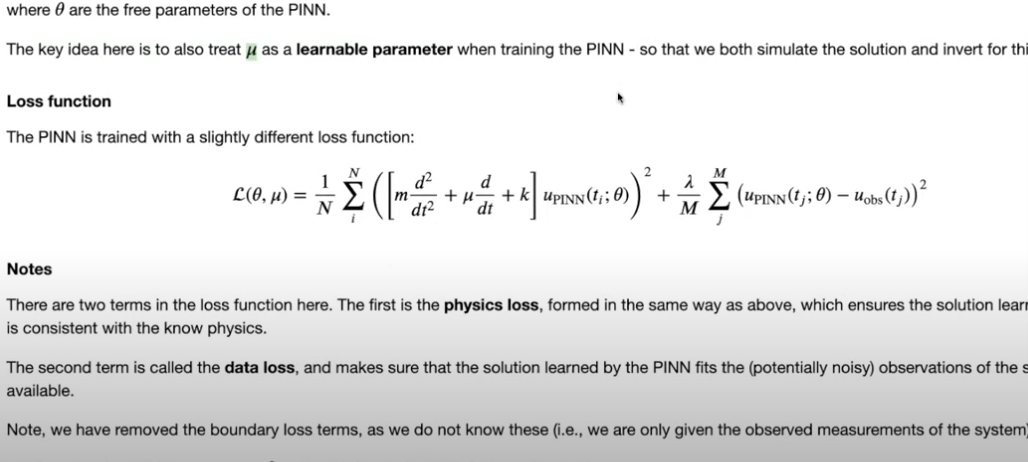

True value of mu: 4


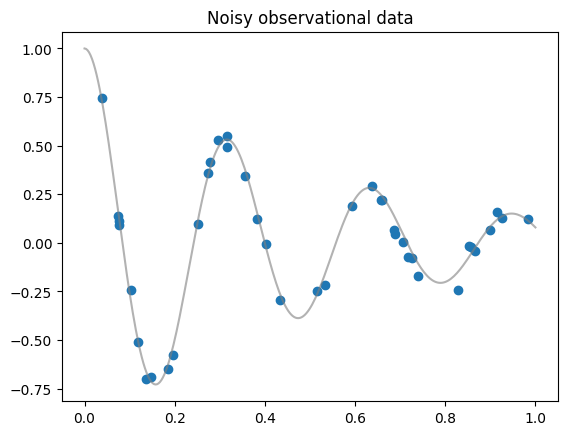

In [ ]:

#first, create some noisy observational data
torch.manual_seed (123)
d, w0 = 2, 20
print (f"True value of mu: {2*d}")
t_obs=torch.rand(40). view (-1,1)
u_obs = exact_solution (d, w0, t_obs) + 0.04*torch.randn_like(t_obs)
plt.figure()
plt.title("Noisy observational data")
plt.scatter (t_obs [:,0], u_obs [:,0])
t_test, u_exact = torch.linspace (0,1,300).view(-1,1), exact_solution (d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", c="grey", alpha=0.6)
plt.show()

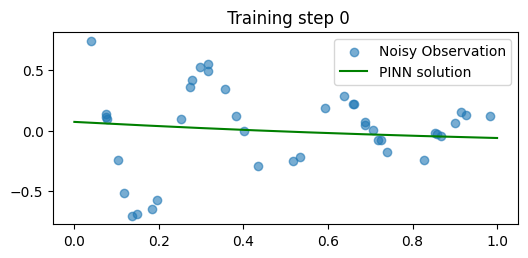

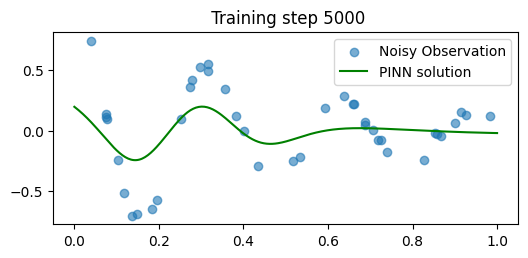

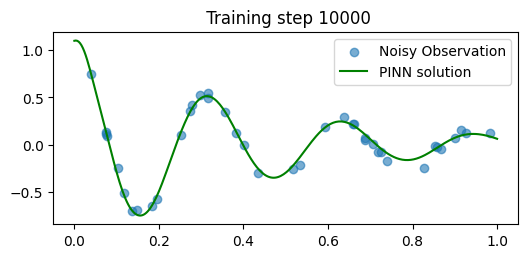

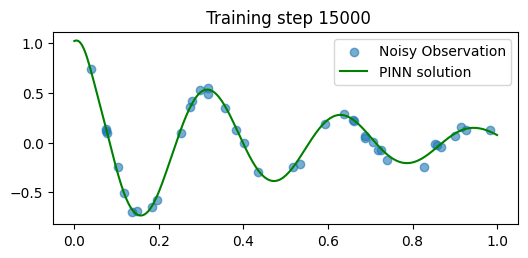

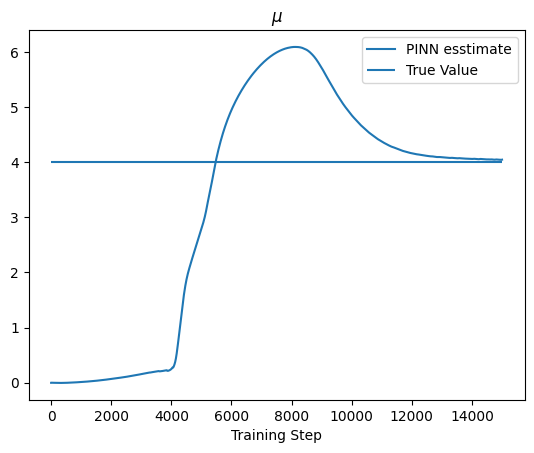

In [ ]:

torch.manual_seed (123)
# define a neural network to train

pinn = FCN (1,1,32,3)
#The requires_grad controls whether gradients should be computed for a tensor during the backward pass.

# define training points over the entire domain, for the physics loss #TODO: write code here
t_physics = torch.linspace (0,1,30).view(-1, 1).requires_grad_(True)
# train the PINN
d, w0 = 2, 20
_, k = 2*d, w0**2

#treating mu as a learnable parameter
mu = torch.nn.Parameter(torch.zeros(1,requires_grad = True))
mus =[]
# t_test = torch.linspace (0,1,300). view (-1,1)

optimiser = torch.optim.Adam (list(pinn. parameters())+[mu], lr=1e-3)
for i in range (15001):
  optimiser.zero_grad()
  #compute each term of the PINN loss function above
  # using the following hyperparameters:
  lambda1 = 1e4

  #physics loss
  u = pinn(t_physics)
  dudt = torch.autograd.grad(u,t_physics,torch.ones_like(u), create_graph = True)[0]
  d2udt2 = torch.autograd.grad(dudt,t_physics,torch.ones_like(dudt), create_graph = True)[0]
  #second derivative
  loss1 = torch.mean((d2udt2+mu*dudt+k*u)**2)

  #data loss
  u = pinn(t_obs)
  loss2 = torch.mean((u-u_obs)**2)

  loss = loss1+ lambda1*loss2
  loss.backward()
  optimiser.step()

  #record mu value
  mus.append(mu.item())

  # plot the result as training progresses
  if i%5000 == 0:
    #print (u. abs(). mean().item(), dudt.abs (). mean().item(), d2udt2.abs (). mean ().item())
    u = pinn (t_test). detach()
    plt.figure(figsize=(6,2.5))
    plt.scatter (t_obs.detach() [:,0],u_obs[:,0],label = "Noisy Observation",alpha=0.6)
    plt.plot(t_test[:,0], u[:,0], label="PINN solution", c="green")
    plt.title(f" Training step {i}")
    plt.legend()
    plt.show()

plt.figure()
plt.title("$\mu$")
plt.plot(mus,label ="PINN esstimate")
plt.hlines(2*d,0,len(mus),label="True Value")
plt.legend()
plt.xlabel("Training Step")
plt.show()